# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

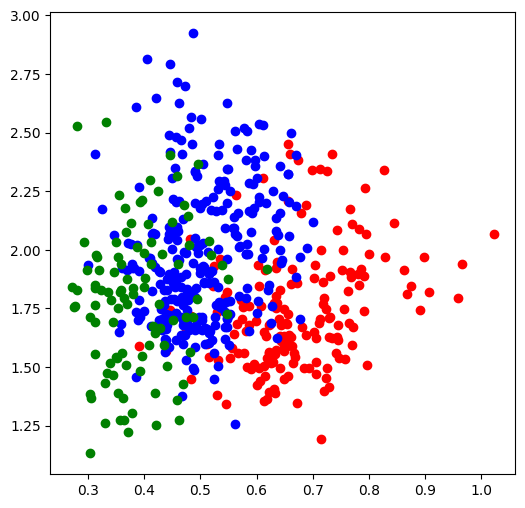

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline
# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']

# Plotting here

plt.figure(figsize=(6,6))
plt.scatter(aes["F1"].values, aes["F2"].values, color='red', label='ae')
plt.scatter(eys["F1"].values, eys["F2"].values, color='blue', label='ey')
plt.scatter(uxs["F1"].values, uxs["F2"].values, color='green', label='ux')
plt.show()


'Ey' vowel (blue) looks the most difficult to classify according to the plot. Its values are overlayed with 'ae' and 'ux' values on F1 and F2.

(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

In [2]:
import scipy.stats

X_columns = ['SpeakerID', 'F1', 'F2']
X_aes, X_eys, X_uxs = aes[X_columns], eys[X_columns], uxs[X_columns]
X_eg = {'ae': X_aes, 'ey': X_eys, 'ux': X_uxs}

class BayesClassificator:
    def __init__(self, X = X_eg, vowels = ['ae', 'ey', 'ux'], features = ['F1', 'F2'], cov_mode: str = 'cov'):
        self.vowels = vowels
        self.features = features
        X_t = { t: X[t][self.features] for t in self.vowels }
        
        self.mean_ = { t: X_t[t].mean() for t in self.vowels }
        self.cov_ = { t: X_t[t].cov() for t in self.vowels } if cov_mode == 'cov' else { t: np.diag(X_t[t].cov()) for t in self.vowels } if cov_mode == 'answer_g' else Exception("Not Implemented")

        len_Xs = 0
        for x in X_t.values(): len_Xs += len(x) 
        len_Xs = len(features)
        self.prior_ = { t: len(X_t[t]) / len_Xs for t in self.vowels }
    
    def likelihood(self, x):
        return { t: scipy.stats.multivariate_normal.pdf(x, mean=self.mean_[t], cov=self.cov_[t]) for t in self.vowels }
    
    def posterior(self, x):
        likelihood_ = self.likelihood(x)
        evidence = self.evidence(x)
        return { t: float(likelihood_[t] * self.prior_[t] / evidence) for t in self.vowels}

    def evidence(self, x):
        likelihood_ = self.likelihood(x)
        return sum(likelihood_[t] * self.prior_[t] for t in self.vowels)

    def predict(self, x):
        posterior_ = self.posterior(x)
        prediction = self.vowels[0]
        for t in self.vowels:
            if posterior_[t] > posterior_[prediction]: prediction = t
        return prediction
        
    def predict_whole_frame(self, X, target):
        error = 0
        
        for x in np.array(X[self.features]):
            if self.predict(x) != target: error += 1
        return error

In [3]:
X = {'ae': X_aes, 'ey': X_eys, 'ux': X_uxs}
vowels = ['ae', 'ey', 'ux']
bc = BayesClassificator()
for k, x in X.items():
    print(f"success for {k} vowel:", 1 - bc.predict_whole_frame(X=x, target=k) / len(x))

success for ae vowel: 0.8208092485549133
success for ey vowel: 0.8621908127208481
success for ux vowel: 0.6


(c) To visualize the classes models and the classifier created in (b), plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$, by using the following function.

In [4]:
import scipy.stats

def plotGaussian(mean, cov, color, ax):
    """ 
        Creates a contour plot for a bi-variate normal distribution
        
        mean: numpy array 2x1 with mean vector
        cov: numpy array 2x2 with covarince matrix
        color: name of color for the plot (see https://matplotlib.org/stable/gallery/color/named_colors.html)
        ax: axis handle where the plot is drawn (can for example be returned by plt.gca() or plt.subplots())
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    mvn = scipy.stats.multivariate_normal(mean, cov)
    lik = mvn.pdf(xy)
    ax.contour(x,y,lik,colors=color)

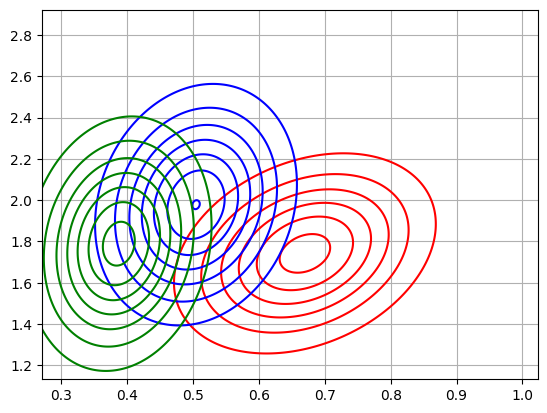

In [5]:
vowels = ['ae', 'ey', 'ux']
colors = { vowels[k]: ['red', 'blue', 'green'][k] for k in range(len(vowels))}
X_ = X_eg

minF1, maxF1 = pd.concat([X_[t]['F1'] for t in vowels]).min(), pd.concat([X_[t]['F1'] for t in vowels]).max()
minF2, maxF2 = pd.concat([X_[t]['F2'] for t in vowels]).min(), pd.concat([X_[t]['F2'] for t in vowels]).max()

_, ax = plt.subplots()
ax.set_xlim(minF1, maxF1), ax.set_ylim(minF2, maxF2)
[plotGaussian(X_[t][['F1','F2']].mean(), X_[t][['F1','F2']].cov(), color=colors[t], ax=ax) for t in vowels]
plt.grid()
plt.show()

*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.

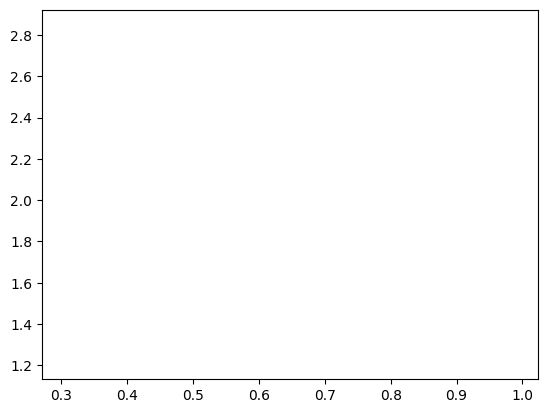

In [6]:
X = {'ae': X_aes[['F1', 'F2']], 'ey': X_eys[['F1', 'F2']], 'ux': X_uxs[['F1', 'F2']]}
bc = BayesClassificator()

posterior_ = {}
for t in bc.vowels:
    for x in np.array(X[t]):
        likelihood_ = bc.likelihood(x)
        evidence = bc.evidence(x)
        posterior_[tuple(x)] = { t: likelihood_[t] * bc.prior_[t] / evidence for t in bc.vowels }
posterior_


argmax = { t: np.array(X[t])[np.argmax([posterior_[tuple(x)][t] for x in np.array(X[t])])] for t in bc.vowels}

_, ax = plt.subplots()
ax.set_xlim(minF1, maxF1), ax.set_ylim(minF2, maxF2)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]

(d) Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test = pd.read_csv("Test.csv")
bc = BayesClassificator()

X_test = { t: np.array(test[test["Phoneme"] == t][['F1', 'F2']]) for t in bc.vowels }


prediction = []
actual = []
for t in bc.vowels:
    for x in X_test[t]:
        prediction.append(bc.predict(x))
        actual.append(t)

print("Confusion matrix of the test set:\n", confusion_matrix(actual, prediction))

Confusion matrix of the test set:
 [[80 24  1]
 [13 97  4]
 [ 1 28 23]]


(e) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (d). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

In [8]:
features = ['F1', 'F2', 'F3', 'F4']
vowels = ['ae', 'ey', 'ux']
X_train = { t: train[train["Phoneme"] == t][features] for t in vowels }

bcF1_F4 = BayesClassificator(X=X_train, features=features)
X_test = { t: test[test["Phoneme"] == t][features] for t in vowels }

print("Model with features F1 - F4 included:\n")
print('Results on training:')
for k, x in X_train.items():
    print(f"success for {k} vowel:", 1 - bcF1_F4.predict_whole_frame(X=x, target=k) / len(x))
print('\nResults on testing:')
for k, x in X_test.items():
    print(f"success for {k} vowel:", 1 - bcF1_F4.predict_whole_frame(X=x, target=k) / len(x))

prediction = []
actual = []
for t in vowels:
    for x in np.array(X_test[t]):
        prediction.append(bcF1_F4.predict(x))
        actual.append(t)

print("\nConfusion matrix of the test set:\n", confusion_matrix(actual, prediction))

Model with features F1 - F4 included:

Results on training:
success for ae vowel: 0.815028901734104
success for ey vowel: 0.8692579505300353
success for ux vowel: 0.65

Results on testing:
success for ae vowel: 0.780952380952381
success for ey vowel: 0.8596491228070176
success for ux vowel: 0.4807692307692307

Confusion matrix of the test set:
 [[82 21  2]
 [13 98  3]
 [ 2 25 25]]


In [9]:
features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']

X_train = { t: train[train["Phoneme"] == t][features] for t in vowels }

bcF1_B4 = BayesClassificator(X=X_train, features=features)
X_test = { t: test[test["Phoneme"] == t][features] for t in vowels }

print("Model with features F1 - F4 - B1 - B4 included:\n")
print('Results on training:')
for k, x in X_train.items():
    print(f"success for {k} vowel:", 1 - bcF1_B4.predict_whole_frame(X=x, target=k) / len(x))
print('\nResults on testing:')
for k, x in X_test.items():
    print(f"success for {k} vowel:", 1 - bcF1_B4.predict_whole_frame(X=x, target=k) / len(x))

predictions = []
actual = []
score = 0
for t in bcF1_B4.vowels:
    for x in np.array(X_test[t]):
        prediction = bcF1_B4.predict(x)
        if prediction == t: score += 1
        predictions.append(prediction)
        actual.append(t)

print("\nScore:", score / len(predictions))
print("\nConfusion matrix of the test set:\n", confusion_matrix(actual, predictions))

Model with features F1 - F4 - B1 - B4 included:

Results on training:
success for ae vowel: 0.8612716763005781
success for ey vowel: 0.8621908127208481
success for ux vowel: 0.7

Results on testing:
success for ae vowel: 0.780952380952381
success for ey vowel: 0.7894736842105263
success for ux vowel: 0.40384615384615385

Score: 0.7121771217712177

Confusion matrix of the test set:
 [[82 23  0]
 [13 90 11]
 [ 3 28 21]]


(f) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (e).

In [10]:
def evaluate_bayes_classificator_with_gender(features = ['F1', 'F2'], cov_mode = 'cov'):
    vowels = ['ae', 'ey', 'ux']
    genders = ['F', 'M']
    X_train = { g: {} for g in genders}
    for t in vowels:
        for g in genders:
            X_train[g][t] = train[(train["Phoneme"] == t) & (train["Gender"] == g)][features]

    bc_features = { g: BayesClassificator(X=X_train[g], features=features, vowels=vowels, cov_mode=cov_mode) for g in genders }

    X_test = { g: {} for g in genders }
    for t in vowels:
        for g in ['F', 'M']:
            X_test[g][t] = test[(test["Phoneme"] == t) & (test["Gender"] == g)][features]
    
    print(f"Model with features {features[0]} - {features[len(features) - 1]} knowing the gender:\n")
    
    train_card_ = { g:{ t: 0 for t in vowels } for g in genders }
    test_card_ = { g:{ t: 0 for t in vowels } for g in genders }

    for t in vowels:
        for g in genders:
            train_card_[g][t] += len(X_train[g][t])
            test_card_[g][t] += len(X_test[g][t])

    scores_train = { g: {} for g in genders }
    scores_test = { g: {} for g in genders }
    for g in genders: 
        for k, x in X_train[g].items():
            scores_train[g][k] = 1 - bc_features[g].predict_whole_frame(X=x, target=k) / len(x)
        for k, x in X_test[g].items():
            scores_test[g][k] = 1 - bc_features[g].predict_whole_frame(X=x, target=k) / len(x)
    
    prediction = []
    actual = []
    for g in genders:
        for t in bc_features[g].vowels:
            for x in np.array(X_test[g][t]):
                prediction.append(bc_features[g].predict(x))
                actual.append(t)

    score_train = 0
    score_test = 0
    total_train = 0
    total_test = 0
    for t in vowels:
        score_train += (scores_train['F'][t] * len(X_train['F'][t]) + scores_train['M'][t] * len(X_train['M'][t])) 
        score_test += (scores_test['F'][t] * len(X_test['F'][t]) + scores_test['M'][t] * len(X_test['M'][t])) 
        total_train += (len(X_train['F'][t]) + len(X_train['M'][t]))
        total_test += (len(X_test['F'][t]) + len(X_test['M'][t]))
        print(f"Score on phoneme {t} on training: {(scores_train['F'][t] * len(X_train['F'][t]) + scores_train['M'][t] * len(X_train['M'][t])) / (len(X_train['F'][t]) + len(X_train['M'][t])) }")
        print(f"Score on phoneme {t} on testing: {(scores_test['F'][t] * len(X_test['F'][t]) + scores_test['M'][t] * len(X_test['M'][t])) / (len(X_test['F'][t]) + len(X_test['M'][t])) }")


    print("\nScore on training:", score_train / total_train)
    print("Score on testing:",  score_test / total_test)
    print("\nConfusion matrix of the test set:\n", confusion_matrix(actual, prediction))

In [11]:
evaluate_bayes_classificator_with_gender(['F1', 'F2'])

Model with features F1 - F2 knowing the gender:

Score on phoneme ae on training: 0.8323699421965318
Score on phoneme ae on testing: 0.8
Score on phoneme ey on training: 0.901060070671378
Score on phoneme ey on testing: 0.8771929824561403
Score on phoneme ux on training: 0.72
Score on phoneme ux on testing: 0.6923076923076923

Score on training: 0.8471223021582733
Score on testing: 0.8118081180811808

Confusion matrix of the test set:
 [[ 84  20   1]
 [ 12 100   2]
 [  1  15  36]]


In [12]:
evaluate_bayes_classificator_with_gender(['F1', 'F2', 'F3', 'F4'])

Model with features F1 - F4 knowing the gender:

Score on phoneme ae on training: 0.8265895953757225
Score on phoneme ae on testing: 0.819047619047619
Score on phoneme ey on training: 0.8763250883392226
Score on phoneme ey on testing: 0.8771929824561403
Score on phoneme ux on training: 0.72
Score on phoneme ux on testing: 0.6346153846153846

Score on training: 0.8327338129496403
Score on testing: 0.8081180811808119

Confusion matrix of the test set:
 [[ 86  18   1]
 [ 11 100   3]
 [  3  16  33]]


In [13]:
evaluate_bayes_classificator_with_gender(['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4'])

Model with features F1 - B4 knowing the gender:

Score on phoneme ae on training: 0.8554913294797688
Score on phoneme ae on testing: 0.8095238095238095
Score on phoneme ey on training: 0.8869257950530035
Score on phoneme ey on testing: 0.7807017543859649
Score on phoneme ux on training: 0.82
Score on phoneme ux on testing: 0.6153846153846154

Score on training: 0.8651079136690647
Score on testing: 0.7601476014760148

Confusion matrix of the test set:
 [[85 20  0]
 [15 89 10]
 [ 3 17 32]]


(g) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (f) using only diagonal covariance matrices and compare the results.

In [14]:
evaluate_bayes_classificator_with_gender(['F1', 'F2', 'F3', 'F4'], cov_mode='answer_g')

Model with features F1 - F4 knowing the gender:

Score on phoneme ae on training: 0.838150289017341
Score on phoneme ae on testing: 0.780952380952381
Score on phoneme ey on training: 0.8480565371024735
Score on phoneme ey on testing: 0.8421052631578947
Score on phoneme ux on training: 0.71
Score on phoneme ux on testing: 0.6538461538461539

Score on training: 0.8201438848920863
Score on testing: 0.7822878228782287

Confusion matrix of the test set:
 [[82 22  1]
 [14 96  4]
 [ 1 17 34]]


In [15]:
evaluate_bayes_classificator_with_gender(['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4'], cov_mode='answer_g')

Model with features F1 - B4 knowing the gender:

Score on phoneme ae on training: 0.8497109826589595
Score on phoneme ae on testing: 0.8380952380952381
Score on phoneme ey on training: 0.8268551236749117
Score on phoneme ey on testing: 0.7631578947368421
Score on phoneme ux on training: 0.78
Score on phoneme ux on testing: 0.6923076923076923

Score on training: 0.8255395683453237
Score on testing: 0.7785977859778598

Confusion matrix of the test set:
 [[88 16  1]
 [19 87  8]
 [ 2 14 36]]


These results are a bit lower than the previous one (except to predict ux on testing). This result is not surprising because we remove a lot of complexity. However this results can be satisfying.

### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

In [16]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

def Plot_SVM_decision_regions(clf,data,labels):
    '''
    This function is for plotting the decision area of SVM
    
    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    phonemes = np.array(["ae","ey","ux"])
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(phonemes)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    # sns.scatterplot(data[:,0],data[:,1],hue=labels)
    plt.scatter(data[:,0],data[:,1])
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Decision Area of SVM')
    plt.show()

def Plot_Support_Vectors(clf,data):
    '''
    This function is for plotting the support vectors of the SVM model
    
    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    label_encoder = LabelEncoder()
    phonemes = np.array(["ae","ey","ux"])
    integer_encoded = label_encoder.fit_transform(phonemes)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Support Vectors')
    plt.show()

(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

In [17]:
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

C = [ 0.1, 1, 10 ]
features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']

X_train_linear = []
y_train_linear = []
X_test_linear = []
y_test_linear = []

for t in vowels:
    for x in np.array(train[(train["Phoneme"] == t)][features]):
        X_train_linear.append(x)
        y_train_linear.append(t)
        
    for x in np.array(test[(test["Phoneme"] == t)][features]):
        X_test_linear.append(x)
        y_test_linear.append(t)

clf_linear = {}
y_pred_linear = {}
score_linear = {}
for c in C:
    # clf_linear[c] = make_pipeline(StandardScaler(), LinearSVC(dual="auto", random_state=0, tol=1e-6, C=c))
    clf_linear[c] = LinearSVC(dual="auto", random_state=0, tol=1e-6, C=c)
    clf_linear[c].fit(X_train_linear, y_train_linear)
    y_pred_linear[c] = clf_linear[c].predict(X_test_linear)
    score_linear[c] = clf_linear[c].score(X_test_linear, y_test_linear)
    print(f"Confusion matrix of linear SVM with penalty term C = {c}:\n", confusion_matrix(y_test_linear, y_pred_linear[c]))
    print('Score (success / length(y)): ', score_linear[c], end="\n\n" )


Confusion matrix of linear SVM with penalty term C = 0.1:
 [[ 74  31   0]
 [ 14 100   0]
 [  7  39   6]]
Score (success / length(y)):  0.6642066420664207

Confusion matrix of linear SVM with penalty term C = 1:
 [[81 24  0]
 [14 97  3]
 [ 5 33 14]]
Score (success / length(y)):  0.7084870848708487

Confusion matrix of linear SVM with penalty term C = 10:
 [[81 23  1]
 [15 96  3]
 [ 4 31 17]]
Score (success / length(y)):  0.7158671586715867



This results are a bit worst than the results found in problem 1 when knowing features F1 to B4 without knowing the gender (except to predict 'ey'). As a reminder, we get: 

Score: 0.7121771217712177

Confusion matrix of the test set:

 [[82 23  0]

 [13 90 11]
 
 [ 3 28 21]]

If we take all the features into consideration, the model in problem 1 seams to be better than the linear SVM model (for every penalty coefficient). We get higher scores and the components of the diagonal of the confusion matrix are higher. 

If we do not look on the gender (as following), we get a similar score than the problem 1 model ($\approx 0.71$). 

In [18]:
C = [ 0.1, 1, 10 ]
features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']
genders = ['F', 'M']

X_train_linear = { g: [] for g in genders}
y_train_linear = { g: [] for g in genders}
X_test_linear = { g: [] for g in genders}
y_test_linear = { g: [] for g in genders}


for g in genders:
    for t in vowels:
        for x in np.array(train[(train["Phoneme"] == t)& (train["Gender"] == g)][features]):
            X_train_linear[g].append(x)
            y_train_linear[g].append(t)
            
        for x in np.array(test[(test["Phoneme"] == t)& (test["Gender"] == g)][features]):
            X_test_linear[g].append(x)
            y_test_linear[g].append(t)

clf_linear = {g: {} for g in genders}
y_pred_linear = {g: {} for g in genders}
score_linear = {g: {} for g in genders}
for c in C:
    print(f"Penalty term C = {c}:")
    for g in genders:
        clf_linear[g][c] = make_pipeline(StandardScaler(), LinearSVC(dual="auto", random_state=0, tol=1e-6, C=c))
        # clf_linear[g][c] = LinearSVC(dual="auto", random_state=0, tol=1e-6, C=c)
        clf_linear[g][c].fit(X_train_linear[g], y_train_linear[g])
        y_pred_linear[g][c] = clf_linear[g][c].predict(X_test_linear[g])
        score_linear[g][c] = clf_linear[g][c].score(X_test_linear[g], y_test_linear[g])
        print(f"Confusion matrix of linear SVM knowing gender {g}\n", confusion_matrix(y_test_linear[g], y_pred_linear[g][c]))
        print(f'Score (success / length(y)), knowing gender {g}: ', score_linear[g][c], end="\n\n" )

Penalty term C = 0.1:
Confusion matrix of linear SVM knowing gender F
 [[26  3  1]
 [ 9 28  2]
 [ 0  7 17]]
Score (success / length(y)), knowing gender F:  0.7634408602150538

Confusion matrix of linear SVM knowing gender M
 [[58 17  0]
 [ 8 63  4]
 [ 1 12 15]]
Score (success / length(y)), knowing gender M:  0.7640449438202247

Penalty term C = 1:
Confusion matrix of linear SVM knowing gender F
 [[26  4  0]
 [ 8 29  2]
 [ 0  6 18]]
Score (success / length(y)), knowing gender F:  0.7849462365591398

Confusion matrix of linear SVM knowing gender M
 [[58 17  0]
 [ 9 64  2]
 [ 1 12 15]]
Score (success / length(y)), knowing gender M:  0.7696629213483146

Penalty term C = 10:
Confusion matrix of linear SVM knowing gender F
 [[25  5  0]
 [ 8 29  2]
 [ 0  6 18]]
Score (success / length(y)), knowing gender F:  0.7741935483870968

Confusion matrix of linear SVM knowing gender M
 [[58 17  0]
 [ 9 64  2]
 [ 1 11 16]]
Score (success / length(y)), knowing gender M:  0.7752808988764045



The results are similar to the one in the previous case.

Linear SVM descision region for C=0.1:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


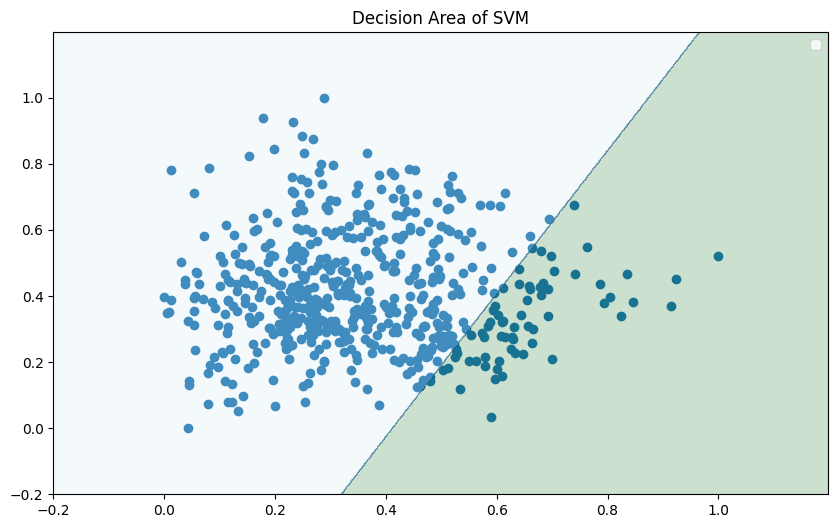

Linear SVM support vector for C=0.1:


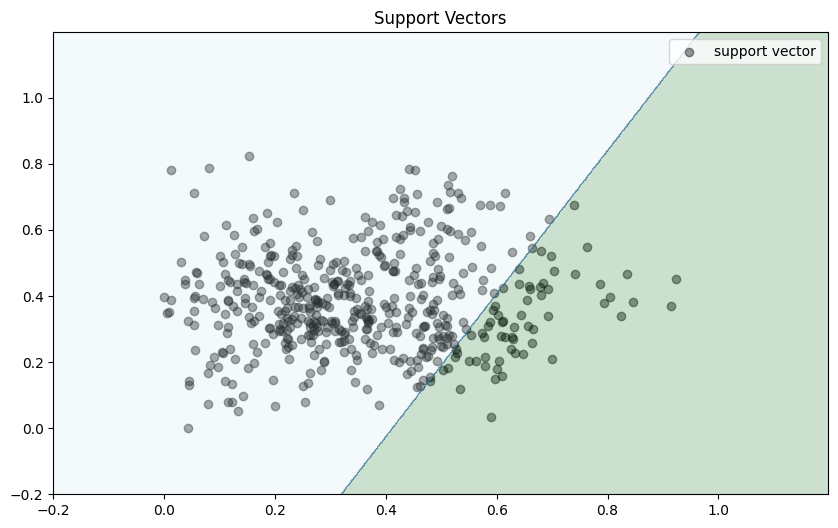

Linear SVM descision region for C=1:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


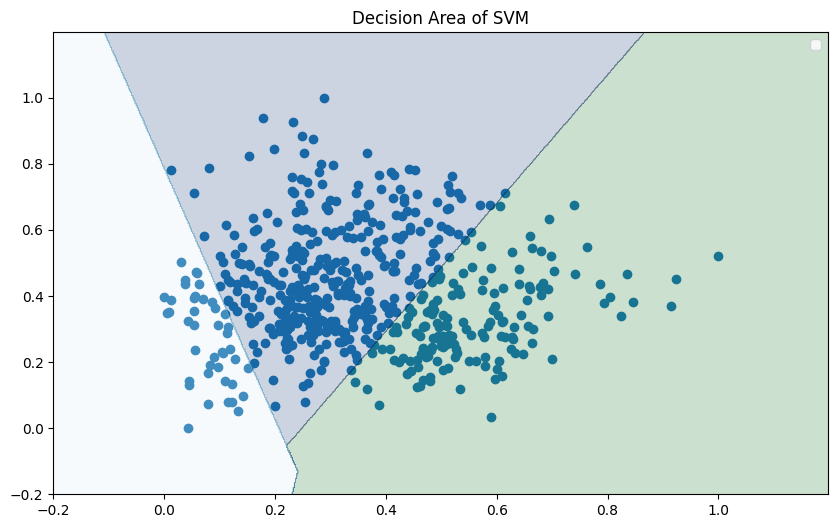

Linear SVM support vector for C=1:


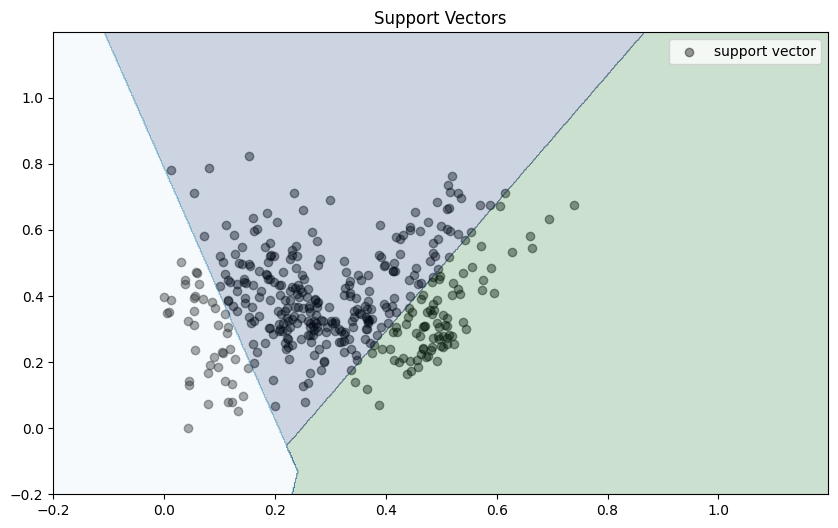

Linear SVM descision region for C=10:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


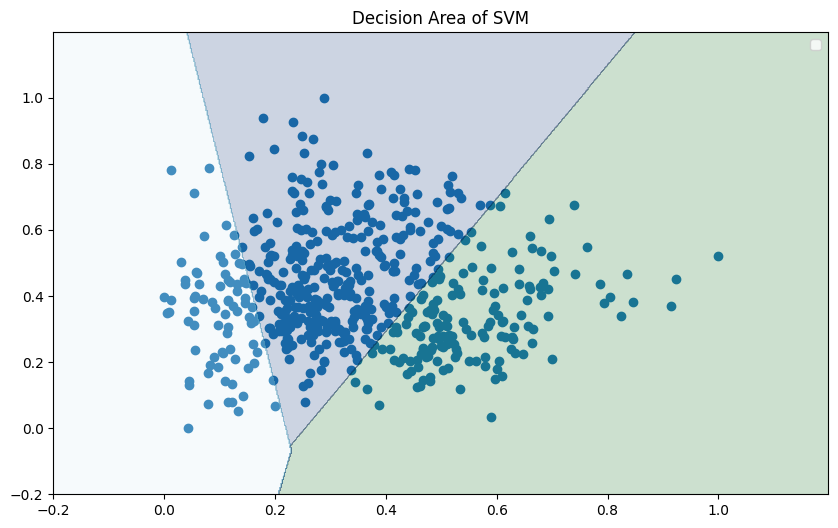

Linear SVM support vector for C=10:


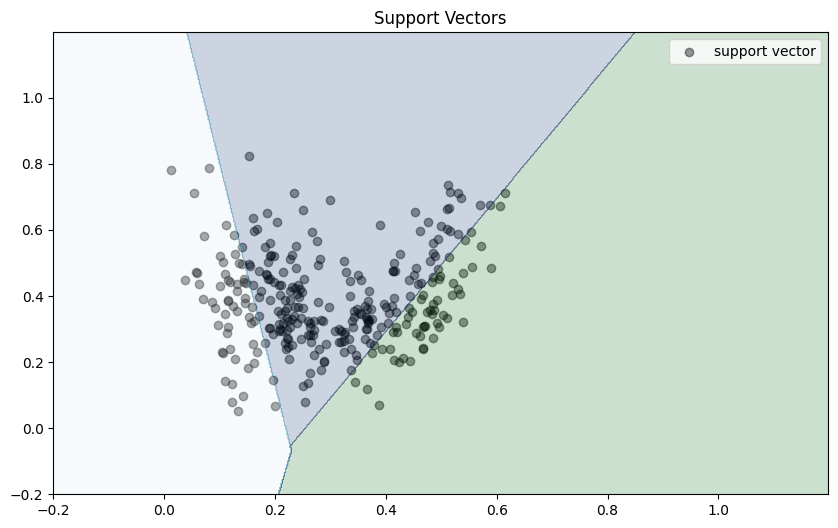

In [19]:
C = [ 0.1, 1, 10 ]

vowel_labels = { vowels[k]: k for k in range(len(vowels)) }
vowel_labels = { vowels[k]: vowels[k] for k in range(len(vowels)) }
features = ['F1', 'F2']
X_train = []
y_train = []
for t in vowels:
    for x in np.array(train[train["Phoneme"] == t][features]):
        X_train.append(x)
        y_train.append(vowel_labels[t])

X_test = []
y_test = []
for t in vowels:
    for x in np.array(test[test["Phoneme"] == t][features]):
        X_test.append(x)
        y_test.append(vowel_labels[t])

clf_linear_to_plot = {}
y_pred = {}
score = {}

X_train, X_test = np.array(X_train), np.array(X_test)
X_train[:, 0] = (X_train[:, 0] - min(X_train[:, 0])) / (max(X_train[:, 0]) - min(X_train[:, 0]))
X_train[:, 1] = (X_train[:, 1] - min(X_train[:, 1])) / (max(X_train[:, 1]) - min(X_train[:, 1]))
X_test[:, 0] = (X_test[:, 0] - min(X_test[:, 0])) / (max(X_test[:, 0]) - min(X_test[:, 0]))
X_test[:, 1] = (X_test[:, 1] - min(X_test[:, 1])) / (max(X_test[:, 1]) - min(X_test[:, 1]))

for c in C:
    clf_linear_to_plot[c] = SVC(kernel='linear', C=c)
    clf_linear_to_plot[c].fit(X_train, y_train)
    y_pred[c] = clf_linear_to_plot[c].predict(X_test)
    score[c] = clf_linear_to_plot[c].score(X_test, y_test)

for c in C:
    print(f"Linear SVM descision region for C={c}:")
    Plot_SVM_decision_regions(clf=clf_linear_to_plot[c], data=X_train, labels=["F1","F2"])
    print(f"Linear SVM support vector for C={c}:")
    Plot_Support_Vectors(clf=clf_linear_to_plot[c], data=X_train)

(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

In [20]:
C = [ 0.1, 1, 10 ]
features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']
kernels = ['rbf', 'poly', 'sigmoid']
X_train = []
y_train = []
X_test = []
y_test = []

for t in vowels:
    for x in np.array(train[(train["Phoneme"] == t)][features]):
        X_train.append(x)
        y_train.append(t)
        
    for x in np.array(test[(test["Phoneme"] == t)][features]):
        X_test.append(x)
        y_test.append(t)

clf = {}
y_pred = {}
score_train = {}
score_test = {}

for k in kernels: 
    clf[k] = {}
    y_pred[k] = {}
    score_train[k] = {}
    score_test[k] = {}
    for c in C:
        clf[k][c] = make_pipeline(StandardScaler(), SVC(kernel=k, C=c))
        clf[k][c].fit(X_train, y_train)
        y_pred[k][c] = clf[k][c].predict(X_test)
        score_train[k][c] = clf[k][c].score(X_train, y_train)
        score_test[k][c] = clf[k][c].score(X_test, y_test)

In [21]:
score_train, score_test

({'rbf': {0.1: 0.7266187050359713,
   1: 0.85431654676259,
   10: 0.9334532374100719},
  'poly': {0.1: 0.6780575539568345,
   1: 0.829136690647482,
   10: 0.8741007194244604},
  'sigmoid': {0.1: 0.7356115107913669,
   1: 0.6816546762589928,
   10: 0.6474820143884892}},
 {'rbf': {0.1: 0.6273062730627307,
   1: 0.6974169741697417,
   10: 0.7011070110701108},
  'poly': {0.1: 0.5793357933579336,
   1: 0.6789667896678967,
   10: 0.6678966789667896},
  'sigmoid': {0.1: 0.6568265682656826,
   1: 0.6125461254612546,
   10: 0.6678966789667896}})

We can see that on training set the score increases with C on both rbf and poly methods. On sigmoid the result is weird, as we can see the score is decreasing.

On the testing set we can see the same thing, except for sigmoid again. It decrease between 0.1 and 1 and then in crease from 1 to 10.

We can see now what happens if we know the gender.

In [22]:
C = [ 0.1, 1, 10 ]
features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']
kernels = ['rbf', 'poly', 'sigmoid']

X_train = { g: [] for g in genders}
y_train = { g: [] for g in genders}
X_test = { g: [] for g in genders}
y_test = { g: [] for g in genders}


for g in genders:
    for t in vowels:
        for x in np.array(train[(train["Phoneme"] == t)& (train["Gender"] == g)][features]):
            X_train[g].append(x)
            y_train[g].append(t)
            
        for x in np.array(test[(test["Phoneme"] == t)& (test["Gender"] == g)][features]):
            X_test[g].append(x)
            y_test[g].append(t)

clf = { k: { g: {} for g in genders } for k in kernels }
y_pred = { k: { g: {} for g in genders } for k in kernels }
score_train = { k: { g: {} for g in genders } for k in kernels }
score_test = { k: { g: {} for g in genders } for k in kernels }

for k in kernels: 
    for g in genders:
        for c in C:
            clf[k][g][c] = make_pipeline(StandardScaler(), SVC(kernel=k, C=c))
            clf[k][g][c].fit(X_train[g], y_train[g])
            y_pred[k][g][c] = clf[k][g][c].predict(X_test[g])
            score_train[k][g][c] = clf[k][g][c].score(X_train[g], y_train[g])
            score_test[k][g][c] = clf[k][g][c].score(X_test[g], y_test[g])

In [23]:
score_train, score_test

({'rbf': {'F': {0.1: 0.6169154228855721,
    1: 0.9253731343283582,
    10: 0.9950248756218906},
   'M': {0.1: 0.723943661971831,
    1: 0.8845070422535212,
    10: 0.9549295774647887}},
  'poly': {'F': {0.1: 0.6368159203980099,
    1: 0.8258706467661692,
    10: 0.9402985074626866},
   'M': {0.1: 0.6563380281690141,
    1: 0.8535211267605634,
    10: 0.9380281690140845}},
  'sigmoid': {'F': {0.1: 0.7213930348258707,
    1: 0.8009950248756219,
    10: 0.7860696517412935},
   'M': {0.1: 0.780281690140845,
    1: 0.7690140845070422,
    10: 0.7126760563380282}}},
 {'rbf': {'F': {0.1: 0.5161290322580645,
    1: 0.7634408602150538,
    10: 0.7419354838709677},
   'M': {0.1: 0.6404494382022472,
    1: 0.7247191011235955,
    10: 0.702247191011236}},
  'poly': {'F': {0.1: 0.5591397849462365,
    1: 0.6881720430107527,
    10: 0.7311827956989247},
   'M': {0.1: 0.601123595505618,
    1: 0.7471910112359551,
    10: 0.7415730337078652}},
  'sigmoid': {'F': {0.1: 0.5806451612903226,
    1: 0.709

We can see that the value of the score depends on a lot of parameters. If we know the gender, when C increase, there is two scenarios. The score increases from 0.1 to 10 or it increases from 0.1 to 1 and then decrease between 1 and 10.

To see the support vectors considering F1 and F2 on all kernels:

In [24]:
C = [ 0.1, 1, 10 ]

features = ['F1', 'F2']
kernels = ['rbf', 'poly', 'sigmoid']
X_train = []
y_train = []
for t in vowels:
    for x in np.array(train[train["Phoneme"] == t][features]):
        X_train.append(x)
        y_train.append(vowel_labels[t])

X_test = []
y_test = []
for t in vowels:
    for x in np.array(test[test["Phoneme"] == t][features]):
        X_test.append(x)
        y_test.append(vowel_labels[t])
clf = {}
y_pred = {}
score_train = {}
score_test = {}

for k in kernels: 
    clf[k] = {}
    y_pred[k] = {}
    score_train[k] = {}
    score_test[k] = {}
    for c in C:
        # clf[k][c] = make_pipeline(StandardScaler(), SVC(kernel=k, C=c))
        clf[k][c] = SVC(kernel=k, C=c)
        clf[k][c].fit(X_train, y_train)
        y_pred[k][c] = clf[k][c].predict(X_test)
        score_train[k][c] = clf[k][c].score(X_train, y_train)
        score_test[k][c] = clf[k][c].score(X_test, y_test)

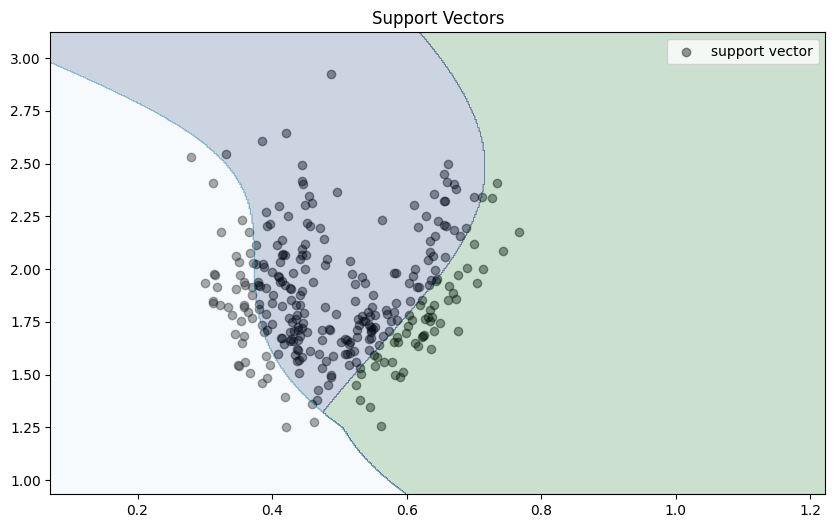

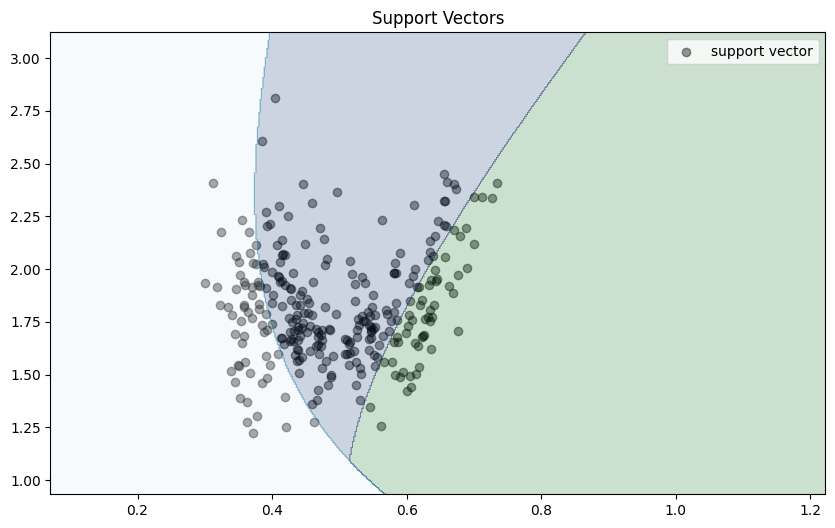

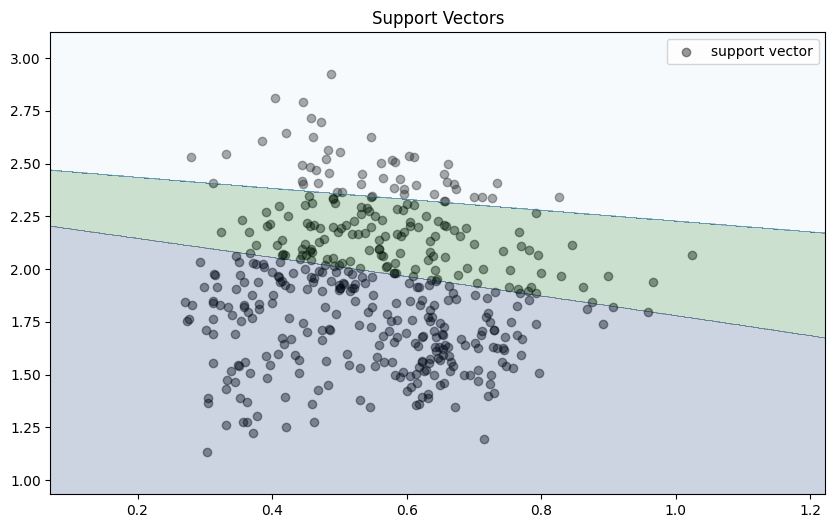

In [25]:
for k in kernels:
    Plot_Support_Vectors(clf=clf[k][c], data=np.array(X_train))